In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meta-platforms-inc-meta/META.csv


# Data Ingestion, Exploration and Preprocessing

In [2]:
df = pd.read_csv("/kaggle/input/meta-platforms-inc-meta/META.csv")
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-05-18,42.049999,45.000000,38.000000,38.230000,38.230000,573576400
1,2012-05-21,36.529999,36.660000,33.000000,34.029999,34.029999,168192700
2,2012-05-22,32.610001,33.590000,30.940001,31.000000,31.000000,101786600
3,2012-05-23,31.370001,32.500000,31.360001,32.000000,32.000000,73600000
4,2012-05-24,32.950001,33.209999,31.770000,33.029999,33.029999,50237200


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2906 non-null   object 
 1   Open       2906 non-null   float64
 2   High       2906 non-null   float64
 3   Low        2906 non-null   float64
 4   Close      2906 non-null   float64
 5   Adj Close  2906 non-null   float64
 6   Volume     2906 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 159.0+ KB


In [4]:
df["Date"] = pd.to_datetime(df["Date"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2906 entries, 0 to 2905
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2906 non-null   datetime64[ns]
 1   Open       2906 non-null   float64       
 2   High       2906 non-null   float64       
 3   Low        2906 non-null   float64       
 4   Close      2906 non-null   float64       
 5   Adj Close  2906 non-null   float64       
 6   Volume     2906 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 159.0 KB


In [6]:
df.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,2906,2906.000000,2906.000000,2906.000000,2906.000000,2906.000000,2.906000e+03
mean,2018-02-26 08:47:14.411562240,156.550165,158.583771,154.572698,156.614814,156.614814,3.068686e+07
min,2012-05-18 00:00:00,18.080000,18.270000,17.549999,17.730000,17.730000,5.467500e+06
25%,2015-04-10 18:00:00,80.504999,81.354999,80.000000,80.669998,80.669998,1.637578e+07
50%,2018-02-27 12:00:00,152.945000,154.680001,151.119995,153.074997,153.074997,2.302375e+07
75%,2021-01-14 18:00:00,202.824997,205.790001,200.262501,203.164997,203.164997,3.524718e+07
max,2023-12-05 00:00:00,381.679993,384.329987,378.809998,382.179993,382.179993,5.735764e+08
std,NaN,90.039390,91.194871,88.936874,90.082156,90.082156,2.642389e+07


In [7]:
#Checking Missing Values
df.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [8]:
df.set_index("Date", inplace = True)

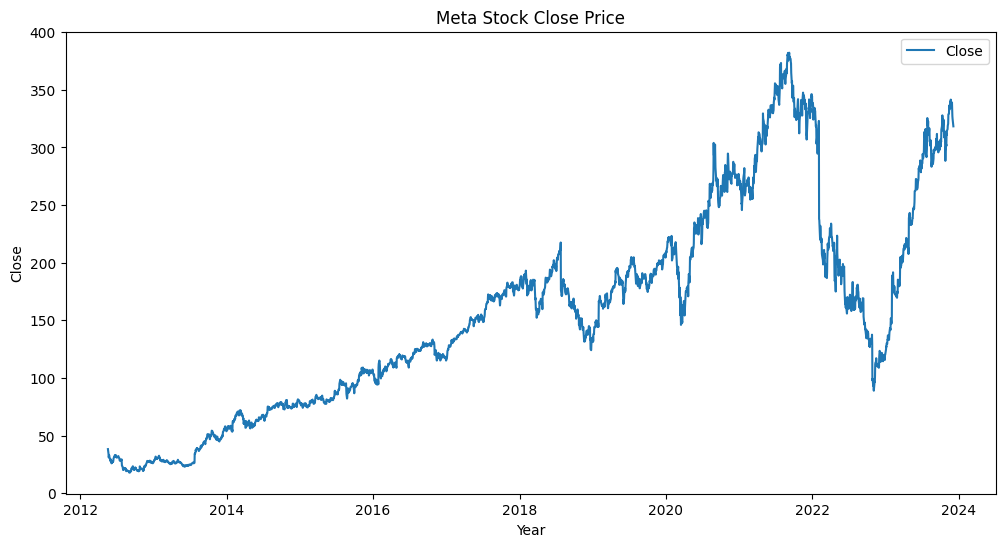

In [9]:
#Visualize of data
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df.loc[df.index , 'Close'])
plt.title('Meta Stock Close Price')
plt.xlabel('Year')
plt.ylabel('Close')
plt.legend(['Close'])
plt.show()

# Moving Average Model

Find the best n to be used in the forecast

In [10]:
optimal_n = None
best_mse = None
db = df.iloc[:, :].values.astype('float32')
mean_results_for_all_possible_n_values = np.zeros(int(len(db) / 2 - 2))
for n in range(3, int(len(db) / 2 + 1)):
    mean_for_n = np.zeros(len(db) - n)
    for i in range(0, len(db) - n):
        mean_for_n[i] = np.power(np.mean(db[:, 0][i:i+n]) - db[i + n][0], 2)
    mean_results_for_all_possible_n_values[n - 3] = np.mean(mean_for_n)
optimal_n = np.argmin(mean_results_for_all_possible_n_values) + 3
best_mse = np.min(mean_results_for_all_possible_n_values)
print("MSE = %s" % mean_results_for_all_possible_n_values)
print("Best MSE = %s" % best_mse)
print("Optimal n = %s" % optimal_n)

MSE = [  26.50009942   31.1841912    35.88798528 ... 8089.32646951 8094.858705
 8100.42282873]
Best MSE = 26.50009941624513
Optimal n = 3


In [11]:
from sklearn.metrics import mean_squared_error

optimal_n = None
best_mse = None

db = df.loc[:,:]
mse = np.zeros(int(len(db) / 2 - 2))
for n in range(3, int(len(db) / 2 + 1)):
    db["Moving_Average"] = db["Close"].rolling(window=n).mean()
    db.dropna(inplace=True)
    mse[n-3] = mean_squared_error(db["Close"], db["Moving_Average"])
    db = df.loc[:,:]
optimal_n = np.argmin(mse) + 3
best_mse = np.min(mse)   
print("MSE = %s" % mse)
print("Best MSE = %s" % best_mse)
print("Optimal n = %s" % optimal_n)

MSE = [   9.95870546   15.59898538   21.04694493 ... 8072.27432851 8077.97705534
 8083.47755981]
Best MSE = 9.9587054617236
Optimal n = 3


In [12]:
n = 3
df["Moving_Average"] = df["Close"].rolling(window=n).mean()
df.dropna(inplace=True)
mse = mean_squared_error(df["Close"], df["Moving_Average"])
print("Mean Squared Error:", mse)
print(df.head(10))

Mean Squared Error: 9.9587054617236
                 Open       High        Low      Close  Adj Close     Volume  \
Date                                                                           
2012-05-22  32.610001  33.590000  30.940001  31.000000  31.000000  101786600   
2012-05-23  31.370001  32.500000  31.360001  32.000000  32.000000   73600000   
2012-05-24  32.950001  33.209999  31.770000  33.029999  33.029999   50237200   
2012-05-25  32.900002  32.950001  31.110001  31.910000  31.910000   37149800   
2012-05-29  31.480000  31.690001  28.650000  28.840000  28.840000   78063400   
2012-05-30  28.700001  29.549999  27.860001  28.190001  28.190001   57267900   
2012-05-31  28.549999  29.670000  26.830000  29.600000  29.600000  111639200   
2012-06-01  28.889999  29.150000  27.389999  27.719999  27.719999   41855500   
2012-06-04  27.200001  27.650000  26.440001  26.900000  26.900000   35230300   
2012-06-05  26.700001  27.760000  25.750000  25.870001  25.870001   42473400   

   

# Forecasting

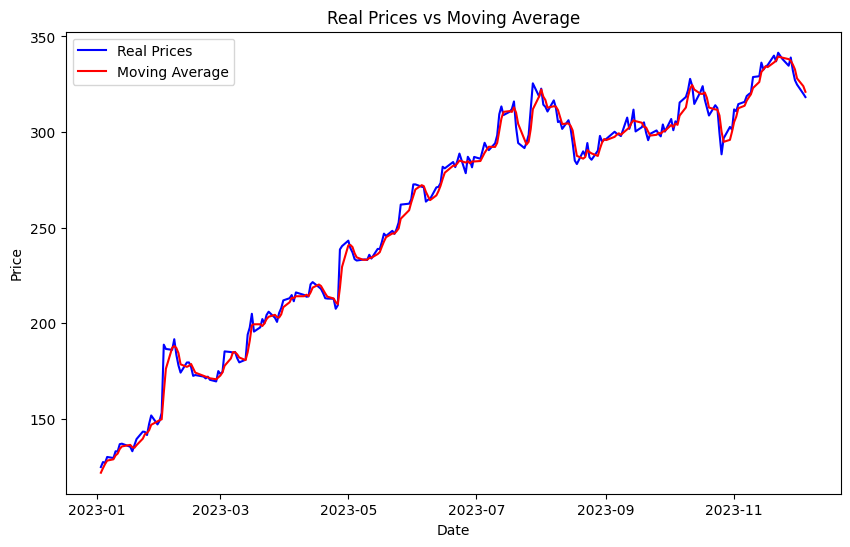

In [13]:
start_date = '2023-01-01'
end_date = '2023-12-31'
filtered_df = df.loc[start_date:end_date]

plt.figure(figsize=(10, 6))
plt.plot(filtered_df.index, filtered_df['Close'], label='Real Prices', color='blue')
plt.plot(filtered_df.index, filtered_df['Moving_Average'], label='Moving Average', color='red')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Real Prices vs Moving Average')
plt.legend()
plt.show()